## Text Summarization of CNN News Articles from 2011 to 2022 Using BART-Base Transformer

Model Named on My HuggingFace Profile: 'bart-base-News_Summarization_CNN'


Source for Dataset: https://www.kaggle.com/datasets/hadasu92/cnn-articles-after-basic-cleaning

### Exploratory Data Analysis

#### Importing Necessary Libraries

In [1]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

import torch
import torch.nn

import pandas as pd
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt

from transformers import set_seed, BartForConditionalGeneration, BartTokenizer
from transformers import DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer 

from datasets import Dataset, DatasetDict, load_metric, load_dataset

#### Versions of Some Necessary Libraries Used

In [2]:
print("Pandas:".ljust(8), pd.__version__)
print("NumPy:".ljust(8), np.__version__)
print("Torch:".ljust(8), torch.__version__)
print("Python:".ljust(8), sys.version[0:6])

Pandas:  1.4.4
NumPy:   1.23.3
Torch:   1.12.1
Python:  3.9.7 


#### Ingest Dataset into Pandas

In [3]:
data_1 = pd.read_csv('~/Desktop/Text Summarization/CNN News/CNN_Articles_clean-LG.csv', encoding_errors='ignore')
data_2 = pd.read_csv('~/Desktop/Text Summarization/CNN News/CNN_Articles_clean-sm.csv', encoding_errors='ignore')

data = pd.concat([data_1, data_2])
data.reset_index(inplace=True, drop=True)
data.drop(columns=['Index', 'Author', 'Date published', 'Category', 'Section', 'Url', 'Headline', 'Keywords', 'Second headline'], inplace=True)
data.rename(columns={ 'Article text' : 'article', 'Description' : 'summary' }, inplace=True)
data.dropna(inplace=True) # 9 articles were dropped
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42016 entries, 0 to 42024
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   summary  42016 non-null  object
 1   article  42016 non-null  object
dtypes: object(2)
memory usage: 984.8+ KB


#### Remove Unnecessary Whitespace

In [4]:
# Replace the '\n' with a space
data.replace('\n', ' ', inplace=True, regex=True)
data.replace('  ', ' ', inplace=True, regex=True)
data.reset_index(drop=True, inplace=True)

data

,summary,article
0,The e-commerce boom has exacerbated a global t...,"(CNN)Right now, there's a shortage of truck d..."
1,Working in a factory can mean doing the same t...,(CNN)Working in a factory or warehouse can me...
2,"In a Hong Kong warehouse, a swarm of autonomou...","(CNN)In a Hong Kong warehouse, a swarm of aut..."
3,Here's a look at how the pandemic reshaped peo...,The pandemic thrust the working world into a n...
4,March Madness isn't just for college basketbal...,New York (CNN Business)March Madness isn't jus...
...,...,...
42011,The Australian Open's Covid-19 vaccine mandate...,(Reuters)The Australian Open's Covid-19 vacci...
42012,Four golfers scheduled to play in the South Af...,(CNN)Four golfers scheduled to play in the So...
42013,Long-time International Olympic Committee (IOC...,(CNN)Long-time International Olympic Committe...
42014,A Norwegian technology company has found a way...,A Norwegian technology company has found a way...


#### Visualize Length of Each Article

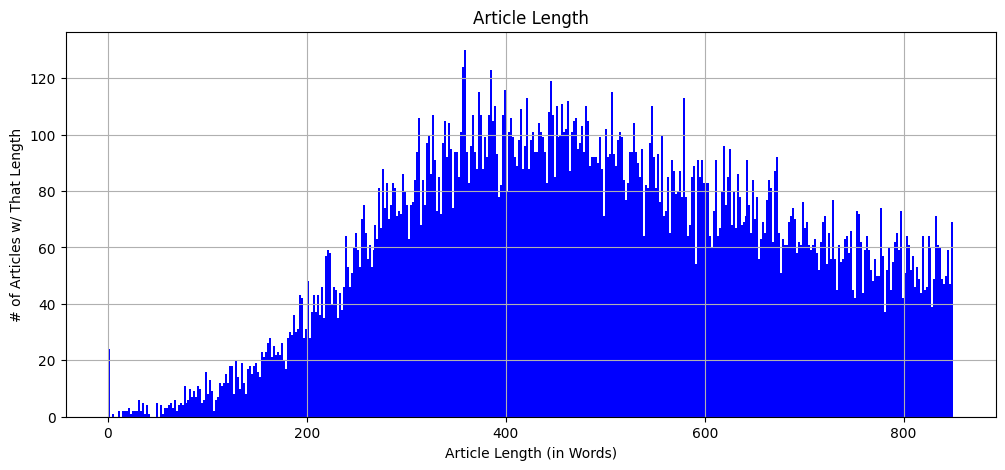

In [5]:
data['article_length'] = data['article'].str.split().apply(len)

data.hist("article_length", grid=True, color="Blue", figsize=(12,5), bins=425, range=(0,850))
plt.suptitle('')
plt.xlabel('Article Length (in Words)')
plt.ylabel('# of Articles w/ That Length')
plt.title('Article Length')
plt.show()

#### Visualize Length of Each Summary

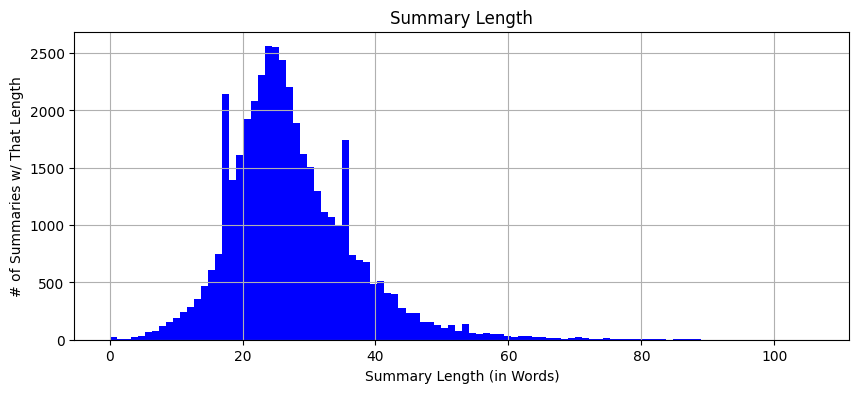

In [6]:
data['summary_length'] = data['summary'].str.split().apply(len)

data.hist("summary_length", grid=True, color="Blue", figsize=(10, 4), bins=100)
plt.suptitle('')
plt.xlabel('Summary Length (in Words)')
plt.ylabel('# of Summaries w/ That Length')
plt.title('Summary Length')
plt.show()

#### Trimmed Dataset Based on Article &/or Summary Length

In [7]:
data = data[data['article_length'] < 820]
data = data[data['summary_length'] < 52]

data = data.drop(columns=['article_length', 'summary_length'])
data

,summary,article
2,"In a Hong Kong warehouse, a swarm of autonomou...","(CNN)In a Hong Kong warehouse, a swarm of aut..."
4,March Madness isn't just for college basketbal...,New York (CNN Business)March Madness isn't jus...
6,Governments around the world must consider dra...,New York (CNN Business)Governments around the ...
8,"Inflation is everywhere: grocery stores, gas s...",New York (CNN Business)Inflation is everywhere...
9,Burger King is trying to suspend its operation...,New York (CNN Business)Burger King is trying t...
...,...,...
42010,French side Troyes has alleged that South Kore...,(CNN)French side Troyes has alleged that Sout...
42011,The Australian Open's Covid-19 vaccine mandate...,(Reuters)The Australian Open's Covid-19 vacci...
42012,Four golfers scheduled to play in the South Af...,(CNN)Four golfers scheduled to play in the So...
42013,Long-time International Olympic Committee (IOC...,(CNN)Long-time International Olympic Committe...


### Actual Project

#### Define Basic Constants/Values

In [8]:
model_ckpt = 'facebook/bart-base'
device="cpu"

max_input_length = 1024
max_target_length = int((52*1.3)+1)

set_seed(42)

#### Convert Pandas DataFrame to Datasets Format; Then Split into Train/Test/Valid Datasets

In [9]:
# Convert pandas dataframe to a dataset
dataset = Dataset.from_pandas(data)

# Split the datasetdict into train/test/valid subsets
train_testvalid = dataset.train_test_split(test_size=0.30)
test_valid = train_testvalid['test'].train_test_split(test_size=0.50)

# Combine the train/test/valid into one datasetdict
dataset = DatasetDict({
    'train' : train_testvalid['train'],
    'test' : test_valid['test'],
    'valid' : test_valid['train']
})

print('Training Data Shape:', dataset['train'].shape)
print('Testing Data Shape:', dataset['test'].shape)
print('Validation Data Shape:', dataset['valid'].shape)

Training Data Shape: (17437, 3)
Testing Data Shape: (3737, 3)
Validation Data Shape: (3737, 3)


#### Make Sure git lfs is Installed; Remember to Enter Access Token

In [10]:
# Access Token from HuggingFace...

!git lfs install

Git LFS initialized.


#### Instantiate both Tokenizer and Model

In [11]:
tokenizer = BartTokenizer.from_pretrained(model_ckpt, truncation=True, padding=True, batched=True, batch_size=None)

pipe = None

model = BartForConditionalGeneration.from_pretrained(model_ckpt)

#### Create Function to Tokenize & Return Necessary Inputs for Batches of Samples

In [12]:
def convert_examples_to_features(ex_batch):
    input_encodings = tokenizer(ex_batch['article'], max_length=max_input_length, truncation=True, padding=True)
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(ex_batch['summary'], max_length=max_target_length, truncation=True, padding=True)
    return {"input_ids" : input_encodings["input_ids"],
            "attention_mask" : input_encodings["attention_mask"],
            "labels" : target_encodings["input_ids"],}

#### Apply Above Function to Dataset

In [13]:
encoded_ds = dataset.map(convert_examples_to_features, batched=True)
encoded_ds.set_format(type="torch", columns=['input_ids', 'labels', 'attention_mask'])

  0%|          | 0/18 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

#### Instantiate TrainingArguments

In [14]:
batch_size = 16
num_of_epochs = 2
learning_rate=2e-5

model_name = f"{model_ckpt.split('/')[-1]}-News_Summarization_CNN"

training_args = Seq2SeqTrainingArguments(output_dir=model_name,
                        num_train_epochs=num_of_epochs,
                        learning_rate=learning_rate,
                        per_device_train_batch_size=1,
                        per_device_eval_batch_size=1,
                        weight_decay=0.01,
                        evaluation_strategy="epoch",
                        save_strategy="epoch",
                        logging_strategy="epoch",
                        logging_first_step=True,
                        warmup_steps=100,
                        disable_tqdm=False,
                        push_to_hub=True,
                        gradient_accumulation_steps=16,
                        log_level="error")

#### Create Function to Computes Metrics

In [15]:
rouge_metric = load_metric("rouge")
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

def chunks(list_of_elements, batch_size):
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def compute_metrics(dataset, metric, model, tokenizer, column_text="Article", column_summary="Summary", batch_size=16, device=device):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))
    
    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        inputs = tokenizer(article_batch, max_length=max_input_length, truncation=True, padding="max_length", return_tensors="pt")
        summaries = model.generate(input_ids=inputs["input_ids"].to(device), 
                                   attention_mask=inputs["attention_mask"].to(device), 
                                   length_penalty=0.8, num_beams=8, max_length=max_target_length)
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, clean_up_tokenization_spaces=True) for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    score = metric.compute()
    return score

#### Instantiate Data Collator

In [16]:
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

#### Instantiate Trainer

In [17]:
trainer = Seq2SeqTrainer(model=model, 
                  args=training_args,
                  data_collator=seq2seq_data_collator,
                  train_dataset=encoded_ds['train'], 
                  eval_dataset=encoded_ds['valid'], 
                  tokenizer=tokenizer) 

Cloning https://huggingface.co/DunnBC22/bart-base-News_Summarization_CNN into local empty directory.


#### Train Model

In [18]:
trainer.train()

/Users/leedunn/Documents/nlpnn/nlp/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/2178 [00:00<?, ?it/s]

{'loss': 8.6945, 'learning_rate': 2.0000000000000002e-07, 'epoch': 0.0}
{'loss': 0.7491, 'learning_rate': 1.0481231953801734e-05, 'epoch': 1.0}


  0%|          | 0/3737 [00:00<?, ?it/s]

{'eval_loss': 0.16182495653629303, 'eval_runtime': 9259.8829, 'eval_samples_per_second': 0.404, 'eval_steps_per_second': 0.404, 'epoch': 1.0}
{'loss': 0.1641, 'learning_rate': 0.0, 'epoch': 2.0}


  0%|          | 0/3737 [00:00<?, ?it/s]

{'eval_loss': 0.16027750074863434, 'eval_runtime': 9262.2796, 'eval_samples_per_second': 0.403, 'eval_steps_per_second': 0.403, 'epoch': 2.0}
{'train_runtime': 335422.6152, 'train_samples_per_second': 0.104, 'train_steps_per_second': 0.006, 'train_loss': 0.4602588941680936, 'epoch': 2.0}


TrainOutput(global_step=2178, training_loss=0.4602588941680936, metrics={'train_runtime': 335422.6152, 'train_samples_per_second': 0.104, 'train_steps_per_second': 0.006, 'train_loss': 0.4602588941680936, 'epoch': 2.0})

### Model Evaluation

#### Compute & Print Metrics

In [19]:
rouge_metric = load_metric("rouge")
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

score = compute_metrics(dataset["test"], 
                        rouge_metric, 
                        trainer.model, 
                        tokenizer, 
                        batch_size=2, 
                        column_text='article', 
                        column_summary='summary')

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"Bart"])

100%|██████████| 1869/1869 [7:40:57<00:00, 14.80s/it]  


,rouge1,rouge2,rougeL,rougeLsum
Bart,0.834343,0.793822,0.823824,0.823778


#### Print Out Full Rouge Metric Dictionary

In [20]:
print("Full Score Dictionary:\n", score)

Full Score Dictionary:
 {'rouge1': AggregateScore(low=Score(precision=0.8465172290593844, recall=0.8230634876648629, fmeasure=0.8253616382865302), mid=Score(precision=0.8554626058292405, recall=0.832143343451353, fmeasure=0.8343428092722153), high=Score(precision=0.864100795850301, recall=0.8410917175302814, fmeasure=0.8430688881451012)), 'rouge2': AggregateScore(low=Score(precision=0.8027988309374968, recall=0.7792167045083119, fmeasure=0.7827912990006063), mid=Score(precision=0.8139825239861607, recall=0.790253158772376, fmeasure=0.7938221833260837), high=Score(precision=0.8242419777572593, recall=0.8001259974854276, fmeasure=0.8038658485984091)), 'rougeL': AggregateScore(low=Score(precision=0.8350250547695109, recall=0.811167477994666, fmeasure=0.8140738072859143), mid=Score(precision=0.8445663668522989, recall=0.8208684193723186, fmeasure=0.8238239740773983), high=Score(precision=0.8535744231866808, recall=0.8300267283303028, fmeasure=0.8327368567020003)), 'rougeLsum': AggregateSco

### Push Fine-Tuned Model to HuggingFace Hub (My Profile)

In [21]:
trainer.push_to_hub(commit_message="All Dunn!")

To https://huggingface.co/DunnBC22/bart-base-News_Summarization_CNN
   f75d28b..fc91e6e  main -> main

   f75d28b..fc91e6e  main -> main

